In [1]:
import numpy as np
import pandas as pd
from tdc.single_pred import ADME
import random
from tdc.benchmark_group import admet_group

from imblearn.over_sampling import SVMSMOTE

from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedShuffleSplit, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import ConfusionMatrixDisplay, auc, precision_recall_curve, roc_curve, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import datetime
now = datetime.datetime.now()
time_stamp = now.strftime("%Y-%m-%d_%H:%M:%S")
print ("Current date and time : ", time_stamp)

global_seed = 8516

Current date and time :  2023-03-22_13:21:29


In [2]:
#Load seed1 validation set predictions
logistic_val_pred_seed1 = pd.read_csv("/data/tdc_bbb_prelim_results1/logistic_fe_aug/val_predictions/val_predictions_seed1.tsv", sep="\t")
print(logistic_val_pred_seed1.shape)
logistic_val_pred_seed1.head()

(203, 4)


,Drug_ID,Actual_value,Predicted_prob,Predicted_class
0,lamotrigine,1,0.938323,1
1,9-C15,1,0.998611,1
2,erizepine,1,0.999255,1
3,amperozide,1,0.999732,1
4,Thioperamide,1,0.940841,1


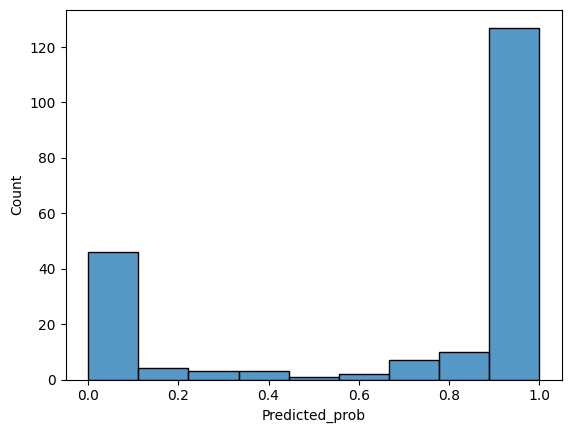

In [3]:
sns.histplot(logistic_val_pred_seed1.Predicted_prob)
plt.show()

In [4]:
#Load seed1 validation set predictions
rf_val_pred_seed1 = pd.read_csv("/data/tdc_bbb_prelim_results1/rf_fe_aug/val_predictions/val_predictions_seed1.tsv", sep="\t")
print(rf_val_pred_seed1.shape)
rf_val_pred_seed1.head()

(203, 4)


,Drug_ID,Actual_value,Predicted_prob,Predicted_class
0,lamotrigine,1,0.627750,1
1,9-C15,1,0.787351,1
2,erizepine,1,0.922308,1
3,amperozide,1,0.804113,1
4,Thioperamide,1,0.825243,1


In [5]:
dnn_val_pred_seed1 = pd.read_csv("/data/tdc_bbb_prelim_results11/dnn_fe_aug/val_predictions/val_predictions_seed1.tsv", sep="\t")


In [6]:
base_learner_preds_val_seed1 = logistic_val_pred_seed1.drop('Predicted_class', axis=1).copy()
base_learner_preds_val_seed1.rename(columns={'Predicted_prob': 'logistic_pred_seed1'}, inplace=True)
base_learner_preds_val_seed1['rf_pred_seed1'] = rf_val_pred_seed1.Predicted_prob
base_learner_preds_val_seed1['dnn_pred_seed1'] = dnn_val_pred_seed1.Predicted_prob

# move id column to index
base_learner_preds_val_seed1.set_index(list(base_learner_preds_val_seed1.columns[[0]]),inplace=True)
base_learner_preds_val_seed1.head()

,Actual_value,logistic_pred_seed1,rf_pred_seed1,dnn_pred_seed1
Drug_ID,,,,
lamotrigine,1,0.938323,0.627750,0.879855
9-C15,1,0.998611,0.787351,0.956551
erizepine,1,0.999255,0.922308,0.998836
amperozide,1,0.999732,0.804113,0.988774
Thioperamide,1,0.940841,0.825243,0.896706


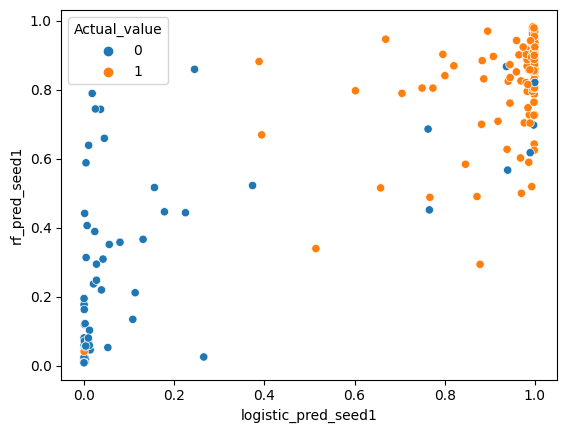

In [7]:
sns.scatterplot(data=base_learner_preds_val_seed1, x='logistic_pred_seed1', y='rf_pred_seed1', hue='Actual_value')
plt.show()

In [8]:
def data_prep(df,scale):
    # split predictors and targets
    X=df.iloc[:,1:]
    features = list(X.columns)
    y=df.iloc[:,0]
    # scale X
    if (scale=="MaxAbsScaler"):
        Xs=MaxAbsScaler().fit_transform(X)
    elif (scale=="StandardScaler"):
        Xs=StandardScaler().fit_transform(X)
    elif (scale=="MinMaxScaler"):
        Xs=MinMaxScaler().fit_transform(X)
    elif (scale=="RowSums"):
        Xs=(X.T / X.T.sum()).T
    else:
        Xs=X
    return Xs,y, features

In [9]:
def augment_data(df):
    print("Before OverSampling, counts of label '0': {}".format(sum(df.iloc[:,0] == 0)))
    print("Before OverSampling, counts of label '1': {} \n".format(sum(df.iloc[:,0] == 1)))
    sm = SVMSMOTE(random_state = 8516)
    X_res, y_res = sm.fit_resample(df.iloc[:,1:], df.iloc[:,0].ravel())
    y_res = pd.DataFrame(y_res, columns=['target'])
    resampled_train_data = pd.DataFrame(pd.concat([y_res, X_res], axis=1))
    print("After OverSampling, counts of label '0': {}".format(sum(resampled_train_data.iloc[:,0] == 0)))
    print("After OverSampling, counts of label '1': {} \n".format(sum(resampled_train_data.iloc[:,0] == 1)))
    return resampled_train_data

In [60]:
def train_logistic(train_df, scale_method):
    X_train,y_train, features_train=data_prep(train_df,scale=scale_method)
    
    from sklearn.metrics import make_scorer
    roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)
    
    sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=global_seed)

    # Perform GridSearchCV to tune best-fit LR model
    param = {
        #'penalty': ['elasticnet'],
        #'penalty': ['l1','l2','elasticnet',None],
        'penalty': ['l1','l2','elasticnet'],
        'C': np.logspace(-2,0,20),
        'class_weight': ['None', 'balanced'], #['None', 'balanced']
        'solver': ['saga'],
        #'solver': ['saga', 'lbfgs', 'liblinear'],
        'l1_ratio': np.logspace(-2,0,20),
        #'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
        'random_state': [global_seed]
    }
    lr_model = LogisticRegression()
    gs_model = GridSearchCV(estimator=lr_model, param_grid=param, cv=sss)
    gs_model.fit(X_train, y_train)
    print("Best Parameters from search: ",gs_model.best_params_)
    # Train a LR model with best parameters
    lr_model = LogisticRegression(**gs_model.best_params_)
    lr_model.fit(X_train, y_train)
    print("Ensemble Model Intercept: ",lr_model.intercept_)
    print("Ensemble Feature Weights: ",lr_model.coef_)
    print(features_train)
    
    return lr_model




In [61]:
# Function to make predictions 

def logistic_predict(trained_model, df, scale_method):
    #split features and targets for modeling
    X_test,y_test, features_test=data_prep(df,scale=scale_method)
    model_prediction_prob = trained_model.predict_proba(X_test)
    model_prediction_prob = model_prediction_prob[:,1]
    model_prediction_class = [1 if pred > 0.5 else 0 for pred in model_prediction_prob]
    return model_prediction_prob, model_prediction_class

In [62]:
augment_data(base_learner_preds_val_seed1).head()

Before OverSampling, counts of label '0': 60
Before OverSampling, counts of label '1': 143 

After OverSampling, counts of label '0': 143
After OverSampling, counts of label '1': 143 



,target,logistic_pred_seed1,rf_pred_seed1,dnn_pred_seed1
0,1,0.938323,0.627750,0.879855
1,1,0.998611,0.787351,0.956551
2,1,0.999255,0.922308,0.998836
3,1,0.999732,0.804113,0.988774
4,1,0.940841,0.825243,0.896706


In [63]:
ensemble_model1 = train_logistic(base_learner_preds_val_seed1, "None")

Best Parameters from search:  {'C': 0.29763514416313175, 'class_weight': 'balanced', 'l1_ratio': 0.7847599703514611, 'penalty': 'elasticnet', 'random_state': 8516, 'solver': 'saga'}
Ensemble Model Intercept:  [-3.24008055]
Ensemble Feature Weights:  [[2.6120105  0.09623141 2.74784715]]
['logistic_pred_seed1', 'rf_pred_seed1', 'dnn_pred_seed1']


In [64]:
#Make predictions on the validation set
val_predicted_prob, val_predicted_class = logistic_predict(ensemble_model1, base_learner_preds_val_seed1, "None")

In [65]:
val_logistic_auc = roc_auc_score(base_learner_preds_val_seed1['Actual_value'], base_learner_preds_val_seed1['logistic_pred_seed1'], average='weighted')
print("\n Val Logistic AUC seed 1: ",val_logistic_auc, "\n")
val_rf_auc = roc_auc_score(base_learner_preds_val_seed1['Actual_value'], base_learner_preds_val_seed1['rf_pred_seed1'], average='weighted')
print("\n Val RF AUC seed 1: ",val_rf_auc, "\n")
val_ensemble_auc = roc_auc_score(base_learner_preds_val_seed1['Actual_value'], val_predicted_prob, average='weighted')
print("\n Val Ensemble AUC seed 1: ",val_ensemble_auc, "\n")


 Val Logistic AUC seed 1:  0.957983682983683 


 Val RF AUC seed 1:  0.9527389277389278 


 Val Ensemble AUC seed 1:  0.9751165501165502 



In [66]:
#Load seed1 test set predictions
logistic_test_pred_seed1 = pd.read_csv("/data/tdc_bbb_prelim_results1/logistic_fe_aug/test_predictions/test_predictions_seed1.tsv", sep="\t")
rf_test_pred_seed1 = pd.read_csv("/data/tdc_bbb_prelim_results1/rf_fe_aug/test_predictions/test_predictions_seed1.tsv", sep="\t")
dnn_test_pred_seed1 = pd.read_csv("/data/tdc_bbb_prelim_results11/dnn_fe_aug/test_predictions/test_predictions_seed1.tsv", sep="\t")


base_learner_preds_test_seed1 = logistic_test_pred_seed1.drop('Predicted_class', axis=1).copy()
base_learner_preds_test_seed1.rename(columns={'Predicted_prob': 'logistic_pred_seed1'}, inplace=True)
base_learner_preds_test_seed1['rf_pred_seed1'] = rf_test_pred_seed1.Predicted_prob
base_learner_preds_test_seed1['dnn_pred_seed1'] = dnn_test_pred_seed1.Predicted_prob

# move id column to index
base_learner_preds_test_seed1.set_index(list(base_learner_preds_test_seed1.columns[[0]]),inplace=True)
base_learner_preds_test_seed1.head()

,Actual_value,logistic_pred_seed1,rf_pred_seed1,dnn_pred_seed1
Drug_ID,,,,
tetrazepam,1,0.999720,0.966064,0.998740
menitrazepam,1,0.996647,0.903289,0.989069
nortetrazepam,1,0.999095,0.936800,0.997423
Oxacillin,0,0.149347,0.087454,0.027071
Flucloxacillin,0,0.102568,0.189799,0.030793


In [67]:
#Make predictions on the test set
test_predicted_prob, test_predicted_class = logistic_predict(ensemble_model1, base_learner_preds_test_seed1, "None")

test_logistic_auc = roc_auc_score(base_learner_preds_test_seed1['Actual_value'], base_learner_preds_test_seed1['logistic_pred_seed1'], average='weighted')
print("\n Test Logistic AUC seed 1: ",test_logistic_auc, "\n")
test_rf_auc = roc_auc_score(base_learner_preds_test_seed1['Actual_value'], base_learner_preds_test_seed1['rf_pred_seed1'], average='weighted')
print("\n Test RF AUC seed 1: ",test_rf_auc, "\n")
test_ensemble_auc = roc_auc_score(base_learner_preds_test_seed1['Actual_value'], test_predicted_prob, average='weighted')
print("\n Test Ensemble AUC seed 1: ",test_ensemble_auc, "\n")


 Test Logistic AUC seed 1:  0.9613430268918073 


 Test RF AUC seed 1:  0.9267120075046905 


 Test Ensemble AUC seed 1:  0.9629455909943714 



In [68]:
print(ensemble_model1.coef_)
print(ensemble_model1.intercept_)

[[2.6120105  0.09623141 2.74784715]]
[-3.24008055]


In [69]:
### Get the TDC train and test split Drug_IDs to split similarly
group = admet_group(path = 'data/')
predictions_list = []

### use the code provided in the TDC website
#### https://tdcommons.ai/benchmark/overview/

for seed in [1, 2, 3, 4, 5]:
    #benchmark = group.get('BBB_Martins')
    #name = benchmark['name']

    #Load validation set base learner predictions to train ensemble model
    logistic_val_pred = pd.read_csv("/data/tdc_bbb_prelim_results11/logistic_fe_aug/val_predictions/val_predictions_seed{}.tsv".format(seed), sep="\t")
    #rf_val_pred = pd.read_csv("/data/tdc_bbb_prelim_results11/rf_fe_aug/val_predictions/val_predictions_seed{}.tsv".format(seed), sep="\t")
    dnn_val_pred = pd.read_csv("/data/tdc_bbb_prelim_results11/dnn_fe_aug/val_predictions/val_predictions_seed{}.tsv".format(seed), sep="\t")
    base_learner_preds_val = logistic_val_pred.drop('Predicted_class', axis=1).copy()
    base_learner_preds_val.rename(columns={'Predicted_prob': 'logistic_pred'}, inplace=True)
    #base_learner_preds_val['rf_pred'] = rf_val_pred.Predicted_prob
    base_learner_preds_val['dnn_pred'] = dnn_val_pred.Predicted_prob
    base_learner_preds_val.set_index(list(base_learner_preds_val.columns[[0]]),inplace=True)
        
    #Load test set base learner predictions as inputs to the ensemble model
    logistic_test_pred = pd.read_csv("/data/tdc_bbb_prelim_results11/logistic_fe_aug/test_predictions/test_predictions_seed{}.tsv".format(seed), sep="\t")
    #rf_test_pred = pd.read_csv("/data/tdc_bbb_prelim_results11/rf_fe_aug/test_predictions/test_predictions_seed{}.tsv".format(seed), sep="\t")
    dnn_test_pred = pd.read_csv("/data/tdc_bbb_prelim_results11/dnn_fe_aug/test_predictions/test_predictions_seed{}.tsv".format(seed), sep="\t")
    base_learner_preds_test = logistic_test_pred.drop('Predicted_class', axis=1).copy()
    base_learner_preds_test.rename(columns={'Predicted_prob': 'logistic_pred'}, inplace=True)
    #base_learner_preds_test['rf_pred'] = rf_test_pred.Predicted_prob
    base_learner_preds_test['dnn_pred'] = dnn_test_pred.Predicted_prob
    base_learner_preds_test.set_index(list(base_learner_preds_test.columns[[0]]),inplace=True)
    
    #Train the ensemble model with validation set base learner predicted probabilities
    ensemble_model = train_logistic(base_learner_preds_val, "None")

    #Make predictions on the test set
    predictions = {}
    #name = benchmark['name']
    name = 'BBB_Martins'
    predicted_prob, predicted_class = logistic_predict(ensemble_model, base_learner_preds_test, "None")
    predictions[name] = predicted_prob

    predictions_list.append(predictions)
    
    # write output files
    # write the above dataframe as .tsv file to use for feature selection
    #test_predictions_df = pd.DataFrame({'Drug_ID':full_test_data_ml.index.values, 'Actual_value':full_test_data_ml.target, 'Predicted_prob':predicted_prob, 'Predicted_class':predicted_class})
    #test_predictions_df.to_csv("../results/{}/test_predictions/test_predictions_seed{}.tsv".format(method_name, seed), sep="\t", index=0)

    #Make predictions on the validation set
    #val_predicted_prob, val_predicted_class = logistic_predict(trained_model, full_valid_data_ml[['target'] + logistic_features_selected], "None")
    # write the above dataframe as .tsv file 
    #val_predictions_df = pd.DataFrame({'Drug_ID':full_valid_data_ml.index.values, 'Actual_value':full_valid_data_ml.target, 'Predicted_prob':val_predicted_prob, 'Predicted_class':val_predicted_class})
    #val_predictions_df.to_csv("../results/{}/val_predictions/val_predictions_seed{}.tsv".format(method_name,seed), sep="\t", index=0)

    test_auc = roc_auc_score(base_learner_preds_test['Actual_value'], predicted_prob, average='weighted')
    print("\n Test AUC seed {}: ".format(seed),test_auc, "\n")
    
print(len(predictions_list))
results = group.evaluate_many(predictions_list)
print(results)

Found local copy...


Best Parameters from search:  {'C': 0.0545559478116852, 'class_weight': 'balanced', 'l1_ratio': 0.01, 'penalty': 'l2', 'random_state': 8516, 'solver': 'saga'}
Ensemble Model Intercept:  [-1.228587]
Ensemble Feature Weights:  [[1.11468185 1.08187495]]
['logistic_pred', 'dnn_pred']

 Test AUC seed 1:  0.9632582864290181 

Best Parameters from search:  {'C': 0.37926901907322497, 'class_weight': 'balanced', 'l1_ratio': 0.7847599703514611, 'penalty': 'elasticnet', 'random_state': 8516, 'solver': 'saga'}
Ensemble Model Intercept:  [-2.80279839]
Ensemble Feature Weights:  [[1.8479314  3.29722384]]
['logistic_pred', 'dnn_pred']

 Test AUC seed 2:  0.9598186366479049 

Best Parameters from search:  {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.01, 'penalty': 'l2', 'random_state': 8516, 'solver': 'saga'}
Ensemble Model Intercept:  [-0.33643009]
Ensemble Feature Weights:  [[0.31695262 0.32505186]]
['logistic_pred', 'dnn_pred']

 Test AUC seed 3:  0.9611866791744841 

Best Parameters from 

Logistic / DNN Base Learner results for comparison
 Test AUC seed 1:  0.9613430268918073 / 0.9482489055659787
 Test AUC seed 2:  0.9562617260787991 / 0.9422881488430268
 Test AUC seed 3:  0.9541119449656035 / 0.9508286429018137
 Test AUC seed 4:  0.9473499061913696 / 0.949851469668543
 Test AUC seed 5:  0.9627892432770482 / 0.9420731707317074
{'bbb_martins': [0.956, 0.006]} / 'bbb_martins': [0.947, 0.004]
